In [10]:
from google.colab import drive
drive.mount('/content/drive/')
%cd drive/MyDrive/resnet_miniproject/

ModuleNotFoundError: No module named 'google'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data

from model import ResidualBlock, ResNet
from train_eval_util import train, evaluate, calculate_accuracy, epoch_time, total_params, total_layers, get_predictions, plot_confusion_matrix
from dataset import train_data, valid_data, test_data

import time
import numpy as np 
import matplotlib.pyplot as plt

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')  
else:
    device = torch.device('cpu')

print(f"Selected device: {device}")

Selected device: cuda


In [ ]:
BATCH_SIZE = 32

train_iterator = DataLoader(train_data, batch_size= BATCH_SIZE, shuffle=True)
valid_iterator =  DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)
test_iterator =  DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
model = ResNet(ResidualBlock, [5, 5, 5]).to(device)

print(f"Total number of layers: {total_layers(model)}")
print(f"Total number of parameters: {total_params(model)}")

from torchsummary import summary
# summary(model)

Total number of layers: 32
Total number of parameters: 466906


In [ ]:
num_epochs = 100
train_acc_history = []
train_loss_history = []
valid_acc_history = []
valid_loss_history = []
lr_epoch = []

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.0001)
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

for epoch in range(num_epochs):

    start_time = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    
    scheduler.step()
    lr_now = lr_now = optimizer.param_groups[0]['lr']
    lr_epoch.append(lr_now)

    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
        
    end_time = time.time()

        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | LR: {lr_now:.6f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    

    train_acc_history.append(train_acc)
    train_loss_history.append( train_loss)
    valid_acc_history.append(valid_acc)
    valid_loss_history.append(valid_loss)

Epoch: 01 | Epoch Time: 0m 58s
	Train Loss: 1.500 | Train Acc: 44.46% | LR: 0.001000
	 Val. Loss: 1.299 |  Val. Acc: 54.42%
Epoch: 02 | Epoch Time: 0m 49s
	Train Loss: 1.047 | Train Acc: 62.98% | LR: 0.000999
	 Val. Loss: 0.940 |  Val. Acc: 66.58%
Epoch: 03 | Epoch Time: 0m 48s
	Train Loss: 0.857 | Train Acc: 70.04% | LR: 0.000998
	 Val. Loss: 0.971 |  Val. Acc: 66.34%
Epoch: 04 | Epoch Time: 0m 48s
	Train Loss: 0.752 | Train Acc: 73.75% | LR: 0.000996
	 Val. Loss: 0.717 |  Val. Acc: 75.88%
Epoch: 05 | Epoch Time: 0m 47s
	Train Loss: 0.680 | Train Acc: 76.43% | LR: 0.000994
	 Val. Loss: 0.647 |  Val. Acc: 77.63%
Epoch: 06 | Epoch Time: 0m 48s
	Train Loss: 0.626 | Train Acc: 78.25% | LR: 0.000991
	 Val. Loss: 0.651 |  Val. Acc: 77.75%
Epoch: 07 | Epoch Time: 0m 48s
	Train Loss: 0.588 | Train Acc: 79.66% | LR: 0.000988
	 Val. Loss: 0.601 |  Val. Acc: 79.34%
Epoch: 08 | Epoch Time: 0m 48s
	Train Loss: 0.554 | Train Acc: 80.90% | LR: 0.000984
	 Val. Loss: 0.587 |  Val. Acc: 79.88%
Epoch: 0

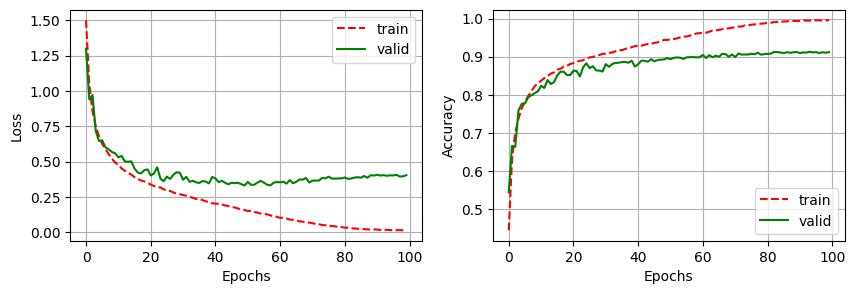

In [ ]:
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ax1.plot(range(num_epochs), train_loss_history, '--r')
ax1.plot(range(num_epochs), valid_loss_history, '-g')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend(['train', 'valid'])

ax2.plot(range(num_epochs), train_acc_history, '--r')
ax2.plot(range(num_epochs), valid_acc_history, '-g')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend(['train', 'valid'])

In [ ]:
torch.save(model, 'model.pt')

In [ ]:
import numpy as np 

np.save( 'history/train_acc_history.npy', train_acc_history)
np.save('history/train_loss_history.npy', train_loss_history )
np.save('history/valid_acc_history.npy', valid_acc_history )
np.save('historyvalid_loss_history.npy', valid_loss_history)
np.save('history/lr_per_epoch.npy', lr_epoch, )

In [11]:
final_model = torch.load('model.pt')
test_loss, test_accurcy = evaluate(final_model, test_iterator, criterion, device)
print(f'test loss: {test_loss:.3f}, validation: {test_accurcy*100:.3f}')

test loss: 0.417, validation: 90.785
